In [1]:

import os
import time
import json
import random
import pathlib
from collections import defaultdict
from typing import Dict, List, Tuple
from tqdm import tqdm

import numpy as np
from tqdm import trange
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from trajdata import AgentBatch, AgentType, UnifiedDataset, SceneBatch
from trajdata.utils.batch_utils import SceneTimeBatcher
from trajdata.data_structures.scene_metadata import Scene as trajdata_Scene
from trajdata.data_structures.state import StateArray, StateTensor
from trajdata.simulation import SimulationScene, sim_metrics, sim_stats, sim_vis
from trajdata.visualization.vis import plot_agent_batch

import trajectron.evaluation as evaluation
import trajectron.visualization as vis
# from trajectron.argument_parser import args
from trajectron.model.online.online_trajectron import OnlineTrajectron
from trajectron.model.model_registrar import ModelRegistrar
from trajectron.environment import Environment, Scene, Node, DoubleHeaderNumpyArray, SceneGraph

In [2]:
arg_device = None
arg_seed = None

if not torch.cuda.is_available() or arg_device == 'cpu':
    arg_device = torch.device('cpu')
else:
    if torch.cuda.device_count() == 1:
        # If you have CUDA_VISIBLE_DEVICES set, which you should,
        # then this will prevent leftover flag arguments from
        # messing with the device allocation.
        arg_device = 'cuda:0'

    arg_device = torch.device(arg_device)

if arg_device is None:
    arg_device = 'cpu'

if arg_seed is not None:
    random.seed(arg_seed)
    np.random.seed(arg_seed)
    torch.manual_seed(arg_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(arg_seed)

In [3]:
log_dir = '/home/abbas/Projects/trajectron/adaptive-trajectron-plus-plus/experiments/pedestrians/kf_models'
model_dir = os.path.join(log_dir, 'eth_1mode_base_tpp-20_Jan_2023_17_38_09')

# Load hyperparameters from json
conf = 'config.json'
config_file = os.path.join(model_dir, conf)
if not os.path.exists(config_file):
    raise ValueError('Config json not found!')
with open(config_file, 'r') as conf_json:
    hyperparams = json.load(conf_json)

output_save_dir = os.path.join(model_dir, 'pred_figs')
pathlib.Path(output_save_dir).mkdir(parents=True, exist_ok=True)

In [4]:

# Load evaluation environments and scenes
attention_radius = defaultdict(
    lambda: 20.0
)  # Default range is 20m unless otherwise specified.
attention_radius[(AgentType.PEDESTRIAN, AgentType.PEDESTRIAN)] = 10.0
attention_radius[(AgentType.PEDESTRIAN, AgentType.VEHICLE)] = 20.0
attention_radius[(AgentType.VEHICLE, AgentType.PEDESTRIAN)] = 20.0
attention_radius[(AgentType.VEHICLE, AgentType.VEHICLE)] = 30.0

dataset = UnifiedDataset(
    # desired_data=["eupeds_eth-test_loo"],
    desired_data=["eupeds_eth-train"],
    centric ="agent",
    history_sec=(hyperparams["history_sec"], hyperparams["history_sec"]),
    future_sec=(hyperparams["prediction_sec"], hyperparams["prediction_sec"]),
    agent_interaction_distances=attention_radius,
    incl_robot_future=hyperparams["incl_robot_node"],
    incl_raster_map=hyperparams["map_encoding"],
    only_predict=[AgentType.PEDESTRIAN],
    no_types=[AgentType.UNKNOWN],
    num_workers=hyperparams["preprocess_workers"],
    cache_location=hyperparams["trajdata_cache_dir"],
    standardize_data=True,
    data_dirs={  # Remember to change this to match your filesystem!
        "eupeds_eth": "/home/abbas/Projects/trajectron/datasets/eth_ucy",
    },
    verbose=True,
)

Loading data for matched scene tags: ['eupeds_eth-zurich-train', 'eupeds_eth-cyprus-train']


Calculating Agent Data (Serially): 100%|██████████| 1/1 [00:00<00:00, 5295.84it/s]

1 scenes in the scene index.



Structuring Agent Data Index: 100%|██████████| 1/1 [00:00<00:00, 582.79it/s]


In [5]:
# Creating a dummy environment with a single scene that contains information about the world.
# When using this code, feel free to use whichever scene index or initial timestep you wish.
scene_idx = 0

# You need to have at least acceleration, so you want 2 timesteps of prior data, e.g. [0, 1],
# so that you can immediately start incremental inference from the 3rd timestep onwards.
init_timestep = 1

In [6]:
# initialize the desired scene

sim_env_name = "eupeds_eth"
scene_name = "biwi_eth-test_loo"
desired_scene: trajdata_Scene = dataset.get_scene(scene_idx)

sim_scene: SimulationScene = SimulationScene(
            env_name=sim_env_name,
            scene_name=scene_name,
            scene=desired_scene,
            dataset=dataset,
            init_timestep=init_timestep,
            freeze_agents=True,
            )
# obs: AgentBatch = sim_scene.reset()

# print(obs.agent_name)
# print(obs.neigh_hist[2].shape)
# # print(obs.neigh_hist_len[2, :obs.num_neigh[2]].unsqueeze(0))
# a = obs.neigh_hist_len[2, :obs.num_neigh[2]].unsqueeze(0)
# print(torch.max(a))
# # print(obs.num_neigh[0].shape)
# print(obs.neigh_types[1, :obs.num_neigh[1]].shape)


In [7]:
# from itertools import product

# hyperparams["pred_state"]
# agent_type = hyperparams["pred_state"].keys()
# print(agent_type)
# print(desired_scene.agent_presence)
# print(list(product(AgentType, repeat=2)))

In [8]:
# initialize online trajectron

model_registrar = ModelRegistrar(model_dir, arg_device)

trajectron = OnlineTrajectron(model_registrar,
                                hyperparams,
                                arg_device)

agent_types = [AgentType.PEDESTRIAN]
edge_types = [(AgentType.PEDESTRIAN, AgentType.PEDESTRIAN)]
# print(edge_types)
# print(agent_type)
# print(edge_types[0])

epoch = 5
model_path = pathlib.Path(model_dir) / f'model_registrar-{epoch}.pt'
checkpoint = torch.load(model_path, map_location=arg_device)
trajectron.load_state_dict(checkpoint["model_state_dict"], strict=False)



_IncompatibleKeys(missing_keys=[], unexpected_keys=['node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_history_encoder.weight_ih_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_history_encoder.weight_hh_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_history_encoder.bias_ih_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_history_encoder.bias_hh_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_future_encoder.weight_ih_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_future_encoder.weight_hh_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_future_encoder.bias_ih_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_future_encoder.bias_hh_l0', 'node_models_dict.PEDESTRIAN.model_registrar.model_dict.PEDESTRIAN/node_future_encoder.weight_ih_l0_reverse', 'node_models_dict.PEDESTRI

In [9]:
trajectron.set_environment(agent_types, edge_types)

Timestep: 2
Agent: 1
Agent: 2


AttributeError: 'str' object has no attribute 'get'

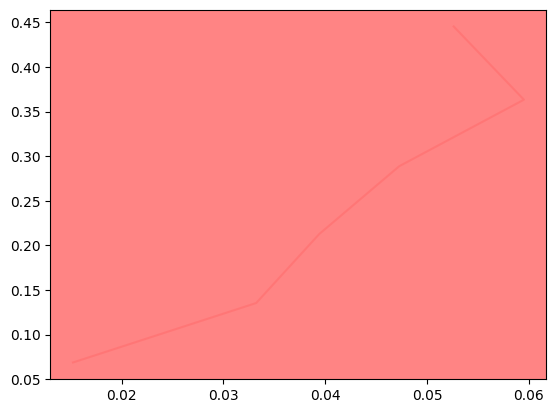

In [ ]:
hyperparams["maximum_history_length"] = int((hyperparams["history_sec"]/sim_scene.scene.dt) + 1)
for t in range(init_timestep+1, sim_scene.scene.length_timesteps):
    print(f"Timestep: {t}")

    try:
        sim_scene: SimulationScene = SimulationScene(
        env_name=sim_env_name,
        scene_name=scene_name,
        scene=desired_scene,
        dataset=dataset,
        init_timestep=t,
        freeze_agents=True,
        )
        obs: AgentBatch = sim_scene.reset()

        start = time.time()
        dists, preds = trajectron.incremental_forward(
            obs=obs,
            maps=None,
            prediction_horizon=6,
            num_samples=1,
            full_dist=True
        )
        end = time.time()

        detailed_preds_dict = dict()
        for name in obs.agent_name:
            if name in preds:
                detailed_preds_dict[name] = preds[name]
    except ValueError as e:
        if str(e)==f"Initial timestep {t} contains no agents after filtering. Please choose another initial timestep.":
            obs = None
        else:
            raise

    # print("t=%d: took %.2f s (= %.2f Hz) w/ %d nodes" % (t, end - start,
    #                                                     1. / (end - start), len(obs.agent_name)))
                                                        # trajectron.scene_graph.get_num_edges()))

    fig, ax = plt.subplots()
    vis.visualize_distribution(ax,
                            dists,
                            batch_idx=0)
    vis.visualize_prediction(ax,
                            {t: preds},
                            sim_scene.scene.dt,
                            max_h=hyperparams['maximum_history_length'],
                            ph=6)
    
    fig.savefig(os.path.join(output_save_dir, f'pred_{t}.pdf'), dpi=300)
    plt.close(fig)